In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from depth_rebasing.Md import Md, normalize
import os
import pandas as pd

512 743


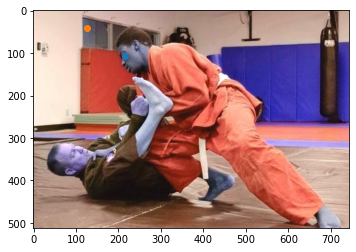

In [73]:
img= cv.imread("/Users/Admin/Documents/UPMC_ISI_2/ML/data/data_new/train/00000080/00080557.jpg")
plt.imshow(img)

x,y,c=img.shape
print(x,y)

# point entre les yeux
xg=int(0.29091*y)
yg=int(0.20713*x)
plt.scatter(xg,yg)

# sommet gauche
plt.scatter(126,40)
#0.17, 0.08,0.67,0.88,0.29091,0.20713

In [71]:
# x1
x1=int(y*0.17)
print(x1)
#y1
y1=int(x*0.08)
print(y1)


126
40


In [68]:
print(xg)

216


In [74]:
imgg=img[y1:y1+(yg-y1)*2,x1:x1+(xg-x1)*2]

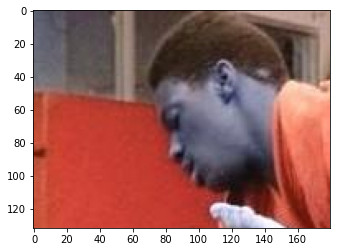

In [75]:
plt.imshow(imgg)

772 512


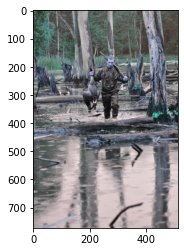

In [78]:
img= cv.imread("/Users/Admin/Documents/UPMC_ISI_2/ML/data/data_new/train/00000080/00080105.jpg")
plt.imshow(img)
a,b,c=img.shape
print(a,b)
#0.42,0.23,0.54773,0.254

In [82]:
x2= int(0.42*b)
y2= int(0.23*a)

xg=int(0.54773*b)
yg=int(0.254*a)

plt.imshow(img)
plt.scatter(x2,y2,color='red',marker='+',s=2)
plt.scatter(xg,yg,color='red',marker='+',s=2)
print(x,y)


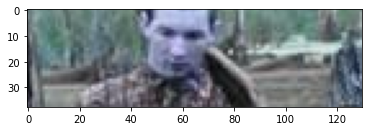

In [86]:
imgg=img[y2:y2+(yg-y2)*2,x2:x2+(xg-x2)*2]
plt.imshow(imgg)

In [2]:
# extract head image
def extract_head(img, xi,yi,xg,yg):
    x,y= np.shape(img)[0:2] # height and width of image
    
    # point entre les yeux
    xg=int(xg*y)
    yg=int(yg*x)
    
    #point sommet gauche
    xi=int(y*xi)
    yi=int(x*yi)
    
    head=img[yi:yi+(yg-yi)*2,xi:xi+(xg-xi)*2]
    return head

In [47]:
def load_images_from_folder(folder):
    images = []
    img_name = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            img_name.append(folder+'/'+filename)
    return images, img_name

In [58]:
path_base_data="/Users/Admin/Documents/UPMC_ISI_2/ML/part_data/train" # database path
annot = "/Users/Admin/Documents/UPMC_ISI_2/ML/part_data/"
path_annotation="/Users/Admin/Documents/UPMC_ISI_2/ML/part_data/train_annotations.txt" #annotation path
directories=[x[0] for x in os.walk(path_base_data)] # list of different directories in database

In [12]:
imgs=[]
imgs_name=[]
imgs_heads=[]
imgs_eyes=[]
heat_map=[]

In [13]:
# for all images
#img=[]
#img_name=[]
#for i in directories[1:]: 
    #img, img_name =load_images_from_folder(i)
    
    #imgs.append(img)
    #imgs_name.append(img_name)
    
path_base_data="/Users/Admin/Documents/UPMC_ISI_2/ML/part_data/train/00000001" # test on one directory
imgs,imgs_name=load_images_from_folder(path_base_data)

In [23]:
# get information from the txt file

with open(path_annotation, 'r') as f:
    annotations = [[num for num in line.split(',')] for line in f]
f.close()
annotations = np.array(annotations)

In [ ]:
# build the head data        
for i in range (np.size(imgs)):    
    l=0
    for k in annotations[:,0]:        
        k=annot+k
        if k==imgs_name[i]:
            img= extract_head(imgs[i],float(annotations[l,2]),float(annotations[l,3]),float(annotations[l,6]),float(annotations[l,7]) )           
    
            imgs_heads.append(img)
        l=l+1

In [64]:
print(np.size(imgs))

1000


C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


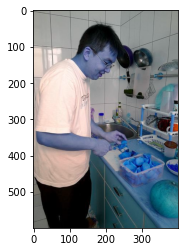

In [56]:
#img=cv.imread(imgs[1])
plt.imshow(imgs[2])
